# Исследование поездок пользователей на самокатах

Заголовок: исследование поездок пользователей на самокатах
    
Описание проекта: В последнее время электрические самокаты стали все чаще появляться на улицах: они относительно дешевые, быстрые и не требуют водительских прав для катания. Проанализировав популярный сервис аренды самокатов GoFast, мы сможем лучше понять поведение клиентов как с подпиской, так и без нее. Правильный анализ этих данных позволит составить примерный портрет пользователя и укажет на возможные изменения, которые необходимо совершить для более комфортного существования сервиса.
    
Цель исследования: описать и визуализировать общую информацию о пользователях и поездках, найти общую помесячную выручку с пользователей, а также проверить некоторые гипотезы по увеличению количества пользователей с подпиской
    
Ход исследования:

    Подготовка данных: загрузка и изучение общей информации из предоставленных датасетов
    
    Предобработка данных: обработка пропущенных значений, удаление дубликатов и т.д.
    
    Исследовательский анализ данных: общая информация о пользователях и поездках
    
    Объединение наборов данных: объединение трех датафреймов в один, разделение на пользователей с подпиской и без нее
    
    Подсчет выручки: добавление нового столбца с помесячной выручкой, высчитанной по специальной формуле
    
    Проверка гипотез: исследование, правдивы ли предположения проджект-менеджеров
    
    Общий вывод: резюмирование полученных результатов, формулировка ключевых выводов и рекомендаций.

С помощью данного исследования мы стремимся дать всесторонний анализ пользователей самокатов сервиса GoFast, а также выявить некие закономерности, которые позволят улучшить работу сервиса

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

## Загрузка данных

In [2]:
users=pd.read_csv('/datasets/users_go.csv')
display(users.head())
users.info()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [3]:
rides=pd.read_csv('/datasets/rides_go.csv')
display(rides.head())
rides.info()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [4]:
subscriptions=pd.read_csv('/datasets/subscriptions_go.csv')
display(subscriptions)
subscriptions.info()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Проанализировав все таблицы, могу сделать вывод, что пропусков в таблицах не обнаружено, в таблице с пользователями 1565 строк, в таблице с поездками 18068 строк, в таблице с подписками две строки. Названия колонок корректны. Также, в таблице с поездками тип данных у столбца с датой "object", хотя должен быть "datetime64".
  

## Предобработка данных

In [5]:
#Изменю тип данных в столбце
rides['date']=pd.to_datetime(rides['date'])
#Создам новый столбец
rides['month']=rides['date'].dt.month
rides

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8
...,...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04,11
18064,1534,2840.423057,21.409799,2021-11-16,11
18065,1534,3826.185507,18.435051,2021-11-18,11
18066,1534,2902.308661,16.674362,2021-11-27,11


In [6]:
#Удалю все явные дубликаты из таблицы с пользователями
users=users.drop_duplicates()
print(users.info())
#Удалю все явные дубликаты из таблицы с поездками 
rides=rides.drop_duplicates()
rides.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 846.9 KB


In [7]:
#Проверю, за какой период у нас данные
print(rides['date'].min(),rides['date'].max())
#Округлю расстояние поездок
rides['distance']=round(rides['distance'])
#Проверю столбец 'duration' на предмет наличия аномалий
rides['duration'].min(),rides['duration'].max()

2021-01-01 00:00:00 2021-12-30 00:00:00


(0.5, 40.82396261922424)

В результате предобработки данных была выявлена и удалена 31 строка-дубликат из таблицы с пользователями. Данные о поездках в таблице содержатся с начала до конца 2021 года включительно. Длительность поездок ранжируется от 30 секунд до почти 41 минуты.


## Исследовательский анализ данных

### Частота встречаемости городов

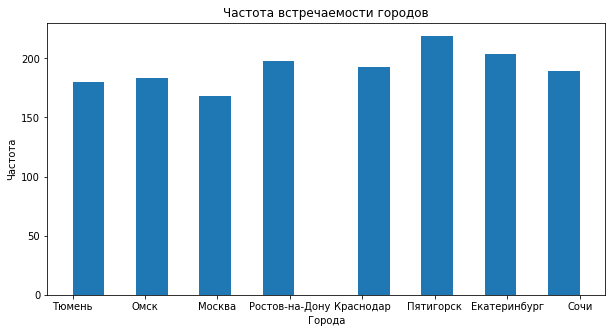

In [8]:
plt.figure(figsize=(10, 5))
plt.hist(users['city'],bins=16)
plt.xlabel('Города')
plt.ylabel('Частота')
plt.title('Частота встречаемости городов')
plt.show()

In [9]:
users['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

Больше всего пользователей из Пятигорска (219), меньше всего из Москвы (168).

### Соотношение пользователей с подпиской и без подписки;

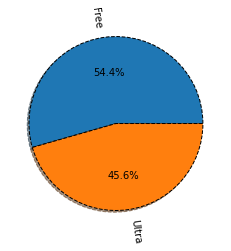

free     835
ultra    699
Name: subscription_type, dtype: int64

In [10]:
plt.pie(users['subscription_type'].value_counts(),labels=['Free','Ultra'],autopct='%1.1f%%', shadow=True, wedgeprops={'lw':1, 'ls':'--','edgecolor':"k"}, rotatelabels=True)
plt.show()
users['subscription_type'].value_counts()

Пользователей без подписки(834) больше, чем пользователей с подпиской(700)

### Возраст пользователей

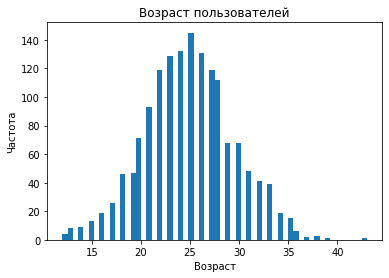

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64


25    145
24    132
26    131
23    129
27    119
22    119
28    112
21     93
20     71
30     68
29     68
31     48
19     47
18     46
32     41
33     39
17     26
34     19
16     19
35     15
15     13
14      9
13      8
36      6
12      4
38      3
37      2
39      1
43      1
Name: age, dtype: int64

In [11]:
plt.hist(users['age'],bins=58)
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.title('Возраст пользователей')
plt.show()
print(users['age'].describe())
users['age'].value_counts()

Замечу, что возраст пользователей распределен нормально. Самое популярное значение возраста у пользователей-25 (145 пользователей)

### Расстояние, которое пользователь преодолел за одну поездку

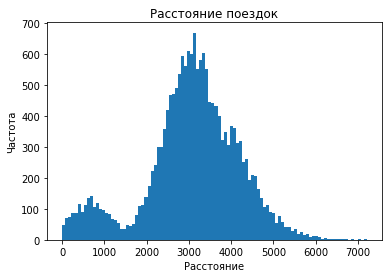

In [12]:
plt.hist(rides['distance'],bins=100)
plt.xlabel('Расстояние')
plt.ylabel('Частота')
plt.title('Расстояние поездок')
plt.show()

Большинство пользователей преодолевает расстояние 2800-3200м. Отмечу также, что от 0 до 600м частота увеличивается, а затем до 1500м уменьшается.

### Продолжительность поездок

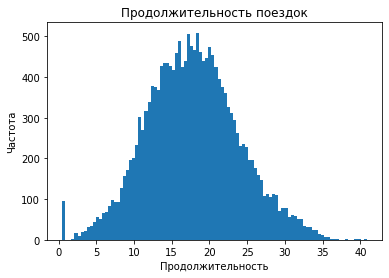

In [13]:
plt.hist(rides['duration'],bins=100)
plt.xlabel('Продолжительность')
plt.ylabel('Частота')
plt.title('Продолжительность поездок')
plt.show()

Можно заметить, что распределение длительностей поездок также максимально приближено к нормальному, самое часто встречающееся значение-около 17 минут.

## Объединение данных

### Создание новой таблицы

In [14]:
alls=users.merge(rides,how='outer',left_on='user_id', right_on='user_id')
alls=alls.merge(subscriptions,how='outer',left_on='subscription_type', right_on='subscription_type')
alls

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4410.0,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2618.0,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.0,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2695.0,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4029.0,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.0,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.0,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.0,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.0,16.674362,2021-11-27,11,8,50,0


In [15]:
#Посмотрю исходную размерность датасетов
print(users.shape,rides.shape,subscriptions.shape)
#Посмотрю размерность таблицы после объединения
print(alls.shape)
#Проверю на пропуски получившуюся таблицу
alls.isna().sum()

(1534, 5) (18068, 5) (2, 4)
(18068, 12)


user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Количество строк в объединенной таблице совпадает с максимальным количеством из трех объединяемых таблиц, а количество столбцов в итоговой таблице равно сумме столбцов объединяемых таблиц, за исключением совпадающих столбцов 'user_id' в таблицах users и rides и 'subscription_type' в users и subscriptions
Пропуски в новой таблице отсутствуют


### Данные о пользователях без подписки

In [16]:
frees=alls.query('subscription_type=="free"').reset_index(drop=True)
frees

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,700,Айдар,22,Омск,free,2516.0,14.944286,2021-01-02,1,8,50,0
1,700,Айдар,22,Омск,free,847.0,16.234663,2021-02-01,2,8,50,0
2,700,Айдар,22,Омск,free,4004.0,20.016628,2021-02-04,2,8,50,0
3,700,Айдар,22,Омск,free,1206.0,9.782872,2021-02-10,2,8,50,0
4,700,Айдар,22,Омск,free,3047.0,17.427673,2021-02-14,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11563,1534,Альберт,25,Краснодар,free,3781.0,19.822962,2021-11-04,11,8,50,0
11564,1534,Альберт,25,Краснодар,free,2840.0,21.409799,2021-11-16,11,8,50,0
11565,1534,Альберт,25,Краснодар,free,3826.0,18.435051,2021-11-18,11,8,50,0
11566,1534,Альберт,25,Краснодар,free,2902.0,16.674362,2021-11-27,11,8,50,0


### Данные о пользователях с подпиской

In [17]:
ultras=alls.query('subscription_type=="ultra"').reset_index(drop=True)
ultras

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4410.0,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2618.0,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.0,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2695.0,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4029.0,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973.0,24.671163,2021-08-29,8,6,0,199
6496,699,Оксана,22,Москва,ultra,3289.0,15.892886,2021-09-12,9,6,0,199
6497,699,Оксана,22,Москва,ultra,3076.0,14.389525,2021-09-26,9,6,0,199
6498,699,Оксана,22,Москва,ultra,4708.0,15.839579,2021-10-17,10,6,0,199


### Информация о расстоянии и времени поездок для пользователей обеих категорий.

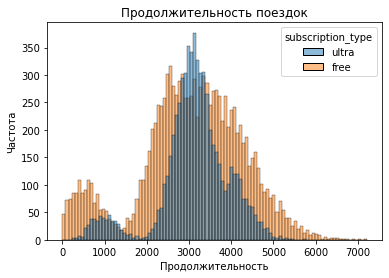

In [18]:
sns.histplot(data=alls,x='distance',bins=100,hue='subscription_type')

plt.xlabel('Продолжительность')
plt.ylabel('Частота')
plt.title('Продолжительность поездок')
plt.show()

Большинство пользователей без подписки проезжают от 2000 до 4000 м, однако также локальный максимум можно обнаружить около 500 м, что говорит о том, что пользователи без подписки не всегда проезжают много(от 0 до 1000)

У пользователей с подпиской парабола более узкая,из-за того, что значений впринципе меньше, а также маленькое количество поездок до 2000 м(ни разу не встретилась частота>50). Самое популярное значение дистанции- 3200

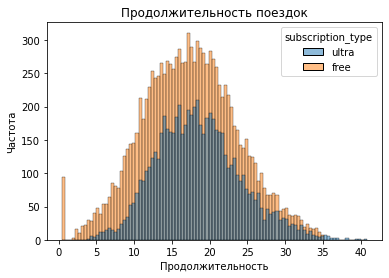

In [19]:
sns.histplot(data=alls,x='duration',bins=100,hue='subscription_type')

plt.xlabel('Продолжительность')
plt.ylabel('Частота')
plt.title('Продолжительность поездок')
plt.show()

Люди без подписки чаще всего катаются от 11 до 22 минут. Также аномально много тех, кто завершил сеанс за минуту(почти 100 значений)

Пользователи с подпиской чаще всего катаются от 14 до 22 минут. Распределение близко к нормальному.

## Подсчёт выручки

In [20]:
viruch=alls.groupby(['user_id','month']).agg(distance_sum=('distance','sum'),distance_count=('distance','count'),duration=('duration','sum'),subscription_type=('subscription_type','first'),start_ride_price=('start_ride_price','first'),minute_price=('minute_price','first'),subscription_fee=('subscription_fee','first'))
viruch['duration']=round(viruch['duration'])
viruch['revenue']=np.ceil(viruch['start_ride_price']*viruch['distance_count']+(viruch['minute_price']*viruch['duration'])+viruch['subscription_fee'])
viruch

distance_sum  distance_count  duration subscription_type  \
user_id month                                                             
1       1            7028.0               2      41.0             ultra   
        4             754.0               1       6.0             ultra   
        8            6724.0               2      45.0             ultra   
        10           5810.0               2      32.0             ultra   
        11           7004.0               3      53.0             ultra   
...                     ...             ...       ...               ...   
1534    6            3409.0               2      25.0              free   
        8            7623.0               2      47.0              free   
        9            4928.0               1      23.0              free   
        11          13349.0               4      76.0              free   
        12           2372.0               1      16.0              free   

               start_ride_price  minute_price  subscription_fee  revenue  
user_id month                                                             
1       1                     0             6               199    445.0  
        4                     0             6               199    235.0  
        8                     0             6               199    469.0  
        10                    0             6               199    391.0  
        11                    0             6               199    517.0  
...                         ...           ...               ...      ...  
1534    6                    50             8                 0    300.0  
        8                    50             8                 0    476.0  
        9                    50             8                 0    234.0  
        11                   50             8                 0    808.0  
        12                   50             8                 0    178.0  

[11331 rows x 8 columns]

## Проверка гипотез

### Правда ли пользователи с подпиской тратят больше времени на поездки

Нулевая гипотеза: пользователи с подпиской тратят столько же или меньше времени на поездки, сколько и пользователи без подписки

Альтернативная гипотеза: пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки

In [21]:
arr1=pd.array(frees['duration'])
print(arr1.median())
arr2=pd.array(ultras['duration'])
print(arr2.median())
results=st.ttest_ind(arr2,arr1,alternative='greater')
results.pvalue

17.326890226082043
18.17815320055055


1.2804098316645618e-34

Поскольку p-value крайне мало, оно меньше статистической значимости, значит нулевая гипотеза отвергается в пользу альтернативной, соответственно пользователи с подпиской действительно тратят больше времени на поездки

### Превышает ли среднее расстояние пользователей с подпиской 3130 метров.

Нулевая гипотеза: среднее расстояние пользователей не превышает 3130 метров
    
Альтернативная гипотеза: среднее расстояние пользователей превышает 3130 метров

In [22]:
arr3=pd.array(ultras['distance'])
results=st.ttest_1samp(arr3,3130,alternative='greater')
results.pvalue

0.9195649894697724

Поскольку p-value больше статистической значимости, равной 1 и 5%, нулевая гипотеза о том, что среднее генеральной совокупности не превышает 3130 метров, не может быть отвергнута

### Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки


Нулевая гипотеза: Помесячная выручка от пользователей с подпиской меньше или равна выручке от пользователей без подписки
    
Альтернативная гипотеза: пользователи с подпиской приносят больше выручки, чем пользователи без подписки

In [23]:
arr4=pd.array(viruch.query('start_ride_price==0')['revenue'])
arr5=pd.array(viruch.query('start_ride_price==50')['revenue'])
results=st.ttest_ind(arr4,arr5,equal_var='False',alternative='greater')
results.pvalue

2.3546897309064956e-37

Поскольку p-value меньше статистической значимости, значит нулевая гипотеза отвергается, а альтернативная гипотеза не отвергается,значит помесячная выручка от пользователей с подпиской больше, чем от пользователей без подписки

## Распределения

### Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10% пользователей. Какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5%?

С помощью цикла и метода binom.pmf найду минимальное значение n, при котором сумма вероятностей получить меньше 100 успехов не превышает 5%

1161


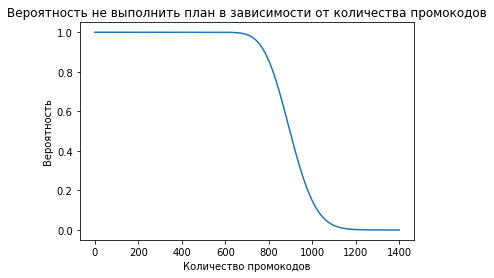

In [24]:
p=0.1
flag=False
distr=[]
for n in range(100,1500):
    val=st.binom.cdf(99,n,p)
    distr.append(val)
    if not flag and val<0.05:
        print(n)
        flag=True
plt.plot(distr)
plt.title("Вероятность не выполнить план в зависимости от количества промокодов")
plt.xlabel("Количество промокодов")
plt.ylabel("Вероятность")
plt.show()

Таким образом, 1161- минимальное количество промокодов, которое нужно разослать.

### Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 %получивших клиентов. Отдел планирует разослать 1млн уведомлений. Какова вероятность того, что уведомление откроют не более 399,5тыс. пользователей?

Воспользуюсь нормальной аппроксимацией биноминального распределения и методом cdf.

In [25]:
from math import sqrt
import scipy.stats as st
n=1000000
p=0.4
mu = n * p
sigma = sqrt(n * p * (1 - p))
distr = st.norm(mu, sigma)
distr.cdf(399500)

0.15371708296369768

Таким образом, вероятность того, что уведомление  откроют не более 399500 пользователей равно около 15.4%

## Вывод.

Проанализировав данные датасеты, можно сказать, что сервисом GoFast за 2021 год пользовались люди от 12 до 43 лет из самых разных городов России: от Москвы(168 пользователей) до Пятигорска(219 пользователей). У сервиса также существует платная подписка, позволяющая снизить стоимость минуты катания(с 8р/мин до 6р/мин), а также избавляющая от платы за начало поездки.
    
Что касается самих поездок, их средняя продолжительность составляет 17 минут и длятся они в среднем 3 км. Можно заметить, что пользователи с подпиской редко проезжают меньше 2 км, возможно потому, что приобретающие подписку любят кататься много, а тариф позволяет им платить меньше. Также, удалось заметить, что пользователи без подписки аномально часто завершают сеанс за минуту(почти 100 значений). Возможно это связано с тем, что пользователи узнали о подписке сразу после начала сеанса и решили приобрести её, перед этим закончив предыдущую поезку.

В целом, пользователи с подпиской тратят больше времени на поездки(18.2 мин против 17.3). Это логично, поскольку подписка позволяет тратить меньше денег, и пользователи с подпиской могут себе позволить более продолжительные поездки. Среднее проезжаемое расстояние пользователей не превышает 3130 метров, а это оптимальное расстояние по износу, поэтому самокаты смогут спокойно отслужить гарантийный срок. Помесячная выручка от пользователей с подпиской больше выручки от пользователей без подписки, а значит выгоднее всего компании продвигать подписку ultra, поскольку люди, имеющие подписку, приносят больше дохода, чем люди без нее.